In [ ]:
! pip install peewee reprobench==0.4.2 seaborn numpy pandas

In [2]:
# db_path = "../output/sudoku-sat-2019.benchmark.db"
db_path = "/Users/rkkautsar/etc/sudoku-sat-2019.benchmark.db"

In [3]:
from playhouse.apsw_ext import APSWDatabase
from reprobench.core.db import db

database = APSWDatabase(db_path)
db.initialize(database)

In [32]:
from peewee import fn, Case, Window
from reprobench.core.db import Run, ParameterGroup, Tool
from reprobench.executors.db import RunStatistic

query = (
    RunStatistic
    .select(
        Tool.name.concat('_').concat(ParameterGroup.name).alias('tool'),
        Run.task_id,
        RunStatistic.run_id,
        RunStatistic.cpu_time,
        RunStatistic.wall_time,
        RunStatistic.max_memory,
    )
    .join(Run)
    .join(ParameterGroup)
    .switch(Run)
    .join(Tool)
    .where(RunStatistic.verdict == RunStatistic.SUCCESS)
    .group_by(RunStatistic.run_id)
)
summary = [d for d in query.dicts()]

In [33]:
import pandas as pd

df = pd.DataFrame(summary)
df = df.fillna(value=pd.np.nan)
df["cpu_time"] = df["cpu_time"].astype(float)
df["wall_time"] = df["wall_time"].astype(float)
df["max_memory"] = df["max_memory"].astype(float)

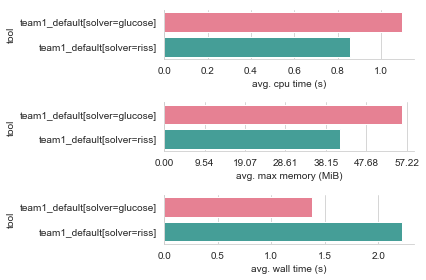

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set_style("whitegrid")

averages = df.groupby("tool")[["cpu_time", "max_memory", "wall_time"]].mean().reset_index()

def average_plot(measure, **kwargs):
    return sns.barplot(x=measure, y="tool", data=averages, palette="husl", **kwargs)

@ticker.FuncFormatter
def megabytes_formatter(x, pos):
    return f"{x / 1024. / 1024. :.2f}"

fig, axs = plt.subplots(nrows=3, sharey=True)
average_plot("cpu_time", ax=axs[0])
average_plot("max_memory", ax=axs[1])
average_plot("wall_time", ax=axs[2])
axs[1].xaxis.set_major_formatter(megabytes_formatter)
axs[1].xaxis.set_major_locator(ticker.AutoLocator())
axs[0].set_xlabel("avg. cpu time (s)")
axs[1].set_xlabel("avg. max memory (MiB)")
axs[2].set_xlabel("avg. wall time (s)")
sns.despine()
plt.tight_layout()
plt.show()

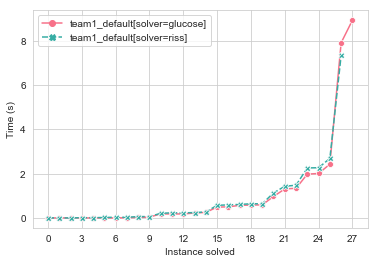

In [35]:
measure = 'cpu_time'
cactus_df = pd.DataFrame()
grouped_by_tool = (
    df
    [["tool", measure]]
    .groupby('tool')[measure]
    .apply(list)
)


for tool, values in grouped_by_tool.items():
    cactus_df = cactus_df.append(
        pd.DataFrame({ tool: sorted(values) }),
        sort=False
    )

plt.xticks()
plt.xlabel("Instance solved")
plt.ylabel("Time (s)")
fig = sns.lineplot(data=cactus_df, palette="husl", markers=True)
fig.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

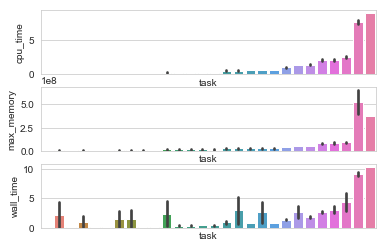

In [72]:
sorted_df = df.sort_values("cpu_time")
fig, axs = plt.subplots(nrows=3, sharex=True)

measures = ["cpu_time", "max_memory", "wall_time"]
for idx, measure in enumerate(measures):
    sns.barplot(data=sorted_df, y=measure, x="task", palette="husl", ax=axs[idx])

plt.xticks([])
plt.show()